# <font color = "green"> Modelo de Dividendos Descontados <font/>
## AXP

<img src = "https://icm.aexp-static.com/Internet/internationalcardshop/es_mx/images/cards/LA_TARJETA_AMERICAN_EXPRESS.png" width="600px" height="150px" /> 

por López Lazareno Diego Alberto

## Modelo General

Cuando un inversor compra una acción generalmente espera recibir dos tipos de flujos de efectivo: dividendos durante el periodo de tenencia del activo y un precio esperado al final de dicho periodo. Ya que éste último se determina por dividendos futuros podemos afirmar que el valor intrínseco de una acción es el valor presente de los dividendos que el inversor espera recibir hasta el infinito.

$$ Valor \space por \space Acción = \sum_{t = 1}^{t = \infty} \frac{E[DPS_t]} {(1 + k_e)^t} $$

donde:

+ $DPS_t$ = Dividendos Esperados por Acción
+ $k_e$ = Tasa de Descuento (Cost of Equity)

Ya que es imposible hacer estimaciones de los dividendos hasta el infinito se han desarrollado varias versiones del modelo de dividendos descontados basadas en distintas suposiciones sobre el crecimiento futuro.

## Modelo de Dividendos Descontados de Dos Etapas

Este modelo permite que existan dos etapas de crecimiento: una fase inicial donde la tasa de crecimiento no es estable y una fase subsecuente donde la tasa de crecimiento es estable y se espera que permanezca de tal forma para el largo plazo. En la mayoría de los casos la tasa de crecimiento durante la fase inicial suele ser más alta que la tasa de crecimiento estable. Sin embargo, el modelo puede ser adaptado para valuar compañías que esperan un crecimiento bajo o negativo por algunos años y que luego revierte a un crecimiento estable.

$$ P_0 = \sum_{t = 1}^{t = n} \frac{DPS_t} {(1 + k_{e, hg})^t} + \frac{P_n}{(1 + k_{e, hg})^n} $$

donde:

+ $P_n = \frac{DPS_{n+1}}{(k_{e, st} - g_n)}$
+ $DPS_t$ = Dividendos Esperados por Acción en el Año $t$
+ $k_e$ = Cost of Equity ($hg$: Fase de Alto Crecimiento, $st$: Fase de Crecimiento Estable)
+ $P_n$ = Valor Terminal (Precio) al Final del Año $n$
+ $g$ = Tasa de Crecimiento Extraordinario (primeros $n$ años)
+ $g_n$ = Tasa de Crecimiento Estable (después del año $n$)

En el caso en que la tasa de crecimiento extraordinaria (inicial) $g$ y el ratio payout no sean alterados para los primeros $n$ años, la anterior fórmula puede ser escrita de la siguiente manera:

$$ P_0 = \frac{DPS_0*(1 + g)*(1 - \frac{(1 + g)^n}{(1 + k_{e, hg})^n})}{k_{e, hg} - g} + \frac{DPS_{n+1}}{(k_{e, st} - g_n)(1 + k_{e, hg})^n} $$



## Introducción Diego

## Introducción Pablo

In [1]:
## Librerías necesarias
# Análisis y manejo de datos
import pandas as pd
import numpy as np

# Yfinance
import yfinance as yf

# Visualización
import matplotlib.pyplot as plt
%matplotlib inline

# Formato de tiempo
import datetime as dt

# Regresión lineal 
from sklearn.linear_model import LinearRegression

# Web scraping
import requests
from bs4 import BeautifulSoup
from fake_useragent import UserAgent

# FMP API
from pyfmpcloud import settings
from pyfmpcloud import company_valuation as cv
api_key = pd.read_csv("Data/apiKey_FMP.csv").iloc[0, 0]
settings.set_apikey(api_key)

In [2]:
# Descarga de estados financieros para el símbolo de cotización
ticker = "AXP"
incomeStatement = cv.income_statement(ticker)
balanceSheet = cv.balance_sheet(ticker)
cashFlowStatement = cv.cash_flow_statement(ticker)

### Datos Fundamentales

In [3]:
# Utilidad neta por acción (último ejercicio fiscal)
eps = incomeStatement["netIncome"].iloc[0] / incomeStatement["weightedAverageShsOut"].iloc[0]
# Dividendos por acción (último ejercicio fiscal)
dps = abs(cashFlowStatement["dividendsPaid"].iloc[0]) / incomeStatement["weightedAverageShsOut"].iloc[0]

fundamentals = pd.DataFrame({"Earnings Per Share" : eps, "Dividends Per Share" : dps}, index = [ticker + " (LFY)"])
fundamentals

,Earnings Per Share,Dividends Per Share
AXP (LFY),3.89441,1.831056


### Tasa de Crecimiento (Fase de Alto Crecimiento)
#### Crecimiento Fundamental & Crecimiento Estimado por Analistas (Zacks)

In [4]:
# Ratio payout y ROE (últimos 5 ejercicios fiscales)
fundamentalGrowth = pd.DataFrame(index = incomeStatement["date"].iloc[0 : 5], columns = ["Payout Ratio", "Return on Equity"])

for i in range(len(fundamentalGrowth)):
    if incomeStatement["netIncome"].iloc[i] > 0:
        fundamentalGrowth.iloc[i, 0] = abs(cashFlowStatement["dividendsPaid"].iloc[i]) / incomeStatement["netIncome"].iloc[i]
    else:
        fundamentalGrowth.iloc[i, 0] = np.nan
        
    if balanceSheet["totalStockholdersEquity"].iloc[i] > 0:
        fundamentalGrowth.iloc[i, 1] = incomeStatement["netIncome"].iloc[i] / balanceSheet["totalStockholdersEquity"].iloc[i]
    else:
        fundamentalGrowth.iloc[i, 1] = np.nan

# Tasa de crecimiento para la fase inicial (estimada por fundamentales)
fundamentalGrowth["Fundamental Growth"] = fundamentalGrowth["Return on Equity"] * (1 - fundamentalGrowth["Payout Ratio"])
payout = np.median(fundamentalGrowth["Payout Ratio"].dropna()) 
roe = np.median(fundamentalGrowth["Return on Equity"].dropna())
g = roe * (1 - payout)

fundamentalGrowth.loc["Median", "Payout Ratio"] = payout
fundamentalGrowth.loc["Median", "Return on Equity"] = roe
fundamentalGrowth.loc["Median", "Fundamental Growth"] = g
fundamentalGrowth

,Payout Ratio,Return on Equity,Fundamental Growth
date,,,
2020-12-31 00:00:00,0.470175,0.136399,0.0722677
2019-12-31 00:00:00,0.210386,0.292965,0.231329
2018-12-31 00:00:00,0.191302,0.310498,0.251099
2017-12-31 00:00:00,0.457237,0.150107,0.0814725
2016-12-31 00:00:00,0.223188,0.263792,0.204917
Median,0.223188,0.263792,0.204917


In [5]:
# Scrapeo de la tasa de crecimiento esperada para los beneficios por acción durante los próximos 5 años (Zacks)
ua = UserAgent()
header = {"User-Agent" : ua.random}

try:
    page = requests.get("https://www.zacks.com/stock/quote/" + ticker, headers=header)
    page_content = page.content
    soup = BeautifulSoup(page_content, "html.parser")

    values = soup.find_all("p", {"class" : "up float_right"})
    growthZacks = float(values[0].get_text().replace("%", "")) / 100

    labels = soup.find_all("dl", {"class" : "abut_bottom"})
    zacksData = []
        
    for row in labels:
        zacksData.append(row.get_text())

    col = zacksData[-3].replace("\n", " ")

except:
    growthZacks = 0
    col = "Exp EPS Growth (3-5yr) 0.00%"
    
zacksEstimates = pd.DataFrame({col : growthZacks}, index = [ticker])
zacksEstimates

,Exp EPS Growth (3-5yr) 20.00%
AXP,0.2


### Tasa de Descuento: Cost of Equity
#### Fase de Alto Crecimiento & Fase de Crecimiento Estable

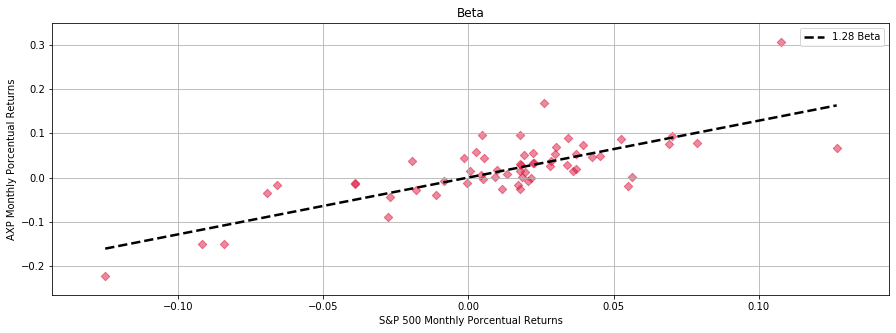

In [6]:
# Obtención de la Beta
end = dt.datetime.today()
start = end - dt.timedelta(365 * 5)

stockPrice = yf.download(ticker, start = start, end = end, progress = False, interval = "1mo").dropna()
marketPrice = yf.download("^GSPC", start = start, end = end, progress = False, interval = "1mo").dropna()

stockReturns = stockPrice[["Adj Close"]].pct_change().dropna()
marketReturns = marketPrice[["Adj Close"]].pct_change().dropna()

x = marketReturns.values
y = stockReturns.values
lr = LinearRegression().fit(x, y)
beta = lr.coef_[0]
x = np.linspace(min(x)[0], max(x)[0], 100)

# Visualización
plt.figure(figsize = (15, 5))
plt.scatter(marketReturns, stockReturns, marker = "D", color = "crimson", alpha = "0.5")
plt.plot(x, beta[0] * x, "--", color = "black", lw = 2.5, label = str(round(beta[0], 2)) + " Beta")
plt.title("Beta")
plt.xlabel("S&P 500 Monthly Porcentual Returns")
plt.ylabel(ticker + " Monthly Porcentual Returns")
plt.legend(loc = "best")
plt.grid();

In [7]:
## CAPM
# Tasa libre de riesgo
rf = yf.download("^TNX", start = start, end = end, progress = False)["Adj Close"][-1] / 100
# Risk Premium (US)
riskPremiums = pd.read_csv("Data/EquityRiskPremiums.csv", index_col = [0])
riskPremium = float(riskPremiums.loc["United  States", "Total Equity Risk Premium"].replace("%", "")) / 100

# Cost of equity (hg)
ke_h = rf + beta[0] * riskPremium
# Cost of equity (st)
ke_s = rf + 1 * riskPremium

capm = pd.DataFrame({"Treasury Yield 10 Years" : rf, "Market Risk Premium" : riskPremium, 
                     "Cost of Equity (High Growth)" : ke_h, "Cost of Equity (Stable Growth)" : ke_s},
                    index = [ticker])
capm

,Treasury Yield 10 Years,Market Risk Premium,Cost of Equity (High Growth),Cost of Equity (Stable Growth)
AXP,0.01245,0.0472,0.073005,0.05965


### Modelo de Dividendos Descontados de Dos Etapas

In [8]:
# Tasa de crecimiento seleccionada (fase inicial)
epsGrowth = 0 * g + 1 * growthZacks
# Tasa de crecimiento estable
pg = rf
# Ratio payout para la fase de crecimiento estable
stablePayout = 1 - pg / ke_s

parameters = pd.DataFrame({"EPS" : eps, "EPS Growth" : epsGrowth, "Payout" : payout,
                           "Perpetual Growth" : pg, "Stable Payout" : stablePayout}, 
                          index = [ticker])
parameters

,EPS,EPS Growth,Payout,Perpetual Growth,Stable Payout
AXP,3.89441,0.2,0.223188,0.01245,0.791282


In [9]:
# Modelo de dividendos descontados
estimates = pd.DataFrame(columns = ["Year 1", "Year 2", "Year 3", "Year 4", "Year 5", "Terminal Value"], 
                         index = ["Earnings Per Share", "Dividends Per Share", "Discount Rate", "Present Value of Dividends"])

for i in range(len(estimates.iloc[0])):
    # Fase de alto crecimiento
    if i != len(estimates.iloc[0]) - 1:
        estimates.iloc[0, i] = eps * (1 + epsGrowth) ** (i + 1)
        estimates.iloc[1, i] = estimates.iloc[0, i] * payout
        estimates.iloc[2, i] = (1 + ke_h) ** (i + 1)
        estimates.iloc[3, i] = estimates.iloc[1, i] / estimates.iloc[2, i]
    
    # Fase de crecimiento estable
    else:
        estimates.iloc[0, i] = estimates.iloc[0, i - 1] * (1 + pg) 
        estimates.iloc[1, i] = estimates.iloc[0, i] * stablePayout
        estimates.iloc[2, i] = ke_s - pg
        estimates.iloc[3, i] = (estimates.iloc[1, i] / estimates.iloc[2, i]) / estimates.iloc[2, i -1]
    
estimates

,Year 1,Year 2,Year 3,Year 4,Year 5,Terminal Value
Earnings Per Share,4.67329,5.60795,6.72954,8.07545,9.69054,9.81119
Dividends Per Share,1.04302,1.25163,1.50195,1.80234,2.16281,7.76342
Discount Rate,1.073,1.15134,1.23539,1.32558,1.42236,0.0472
Present Value of Dividends,0.972057,1.08711,1.21577,1.35966,1.52058,115.639


### Valor Intrínseco por Acción

In [10]:
# Cotización
stockPrice = yf.download(ticker, start = start, end = end, progress = False)["Adj Close"]
# Valor intrínseco
intrinsicValue = estimates.loc["Present Value of Dividends"].sum()

valuation = pd.DataFrame({"Intrinsic Value Per Share" : intrinsicValue, "Current Price" : stockPrice[-1], 
                          "Margin of Safety" : 1 - stockPrice[-1] / intrinsicValue}, 
                          index = [ticker])
valuation

,Intrinsic Value Per Share,Current Price,Margin of Safety
AXP,121.793828,164.449997,-0.350233


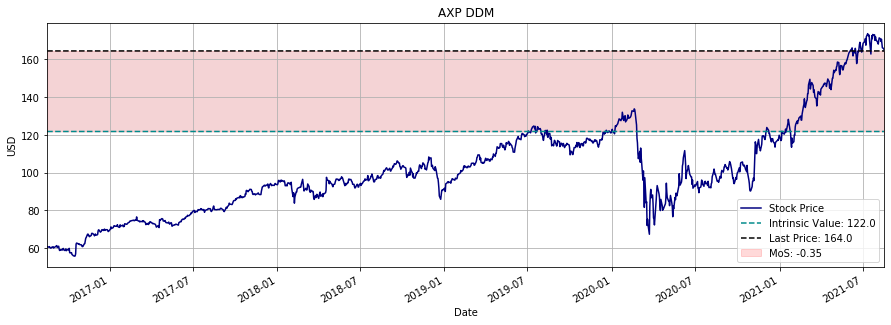

In [11]:
# Visualización
stockPrice.plot(figsize = (15, 5), color = "navy", label = "Stock Price")
plt.plot(stockPrice.index, np.ones(len(stockPrice)) * intrinsicValue, "--", label = "Intrinsic Value: " + str(round(intrinsicValue)), color = "darkcyan")
plt.plot(stockPrice.index, np.ones(len(stockPrice)) * stockPrice[-1], "--", label = "Last Price: " + str(round(stockPrice[-1])), color = "black")
plt.fill_between(stockPrice.index, stockPrice[-1], intrinsicValue, alpha = 0.05)

if intrinsicValue > stockPrice[-1]:
    plt.fill_between(stockPrice.index, stockPrice[-1], intrinsicValue, alpha = 0.15, color = "green", label = "MoS: " + str(round(1 - stockPrice[-1] / intrinsicValue, 2)))
else:
    plt.fill_between(stockPrice.index, stockPrice[-1], intrinsicValue, alpha = 0.15, color = "red", label = "MoS: " + str(round(1 - stockPrice[-1] / intrinsicValue, 2)))

plt.title(ticker + " DDM")
plt.xlabel("Date")
plt.ylabel("USD")
plt.legend(loc = "best")
plt.grid();

### Referencias Consultadas:

+ Damodaran, A. (2011). The Little Book of Valuation. New Jersey: Wiley.